# Chapter 7

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
import numpy as np


import thinkstats2
import thinkplot

## Scatter plots

I'll start with the data from the BRFSS again.

In [4]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/brfss.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/CDBRFS08.ASC.gz")

In [5]:
import brfss


df = brfss.ReadBrfss(nrows=None)

/Users/joaquincordero/Desktop/Masters/DSC 530/ThinkStats2-master/code/brfss.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df.age.replace([7, 9], float('NaN'), inplace=True)
/Users/joaquincordero/Desktop/Masters/DSC 530/ThinkStats2-master/code/brfss.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values 

The following function selects a random subset of a `DataFrame`.

In [16]:
def SampleRows(df, nrows, replace=False):
    indices = np.random.choice(df.index, nrows, replace=replace)
    sample = df.loc[indices]
    return sample

I'll extract the height in cm and the weight in kg of the respondents in the sample.

In [19]:
sample = SampleRows(df, 5000)
heights, weights = sample.htm3, sample.wtkg2

Here's a simple scatter plot with `alpha=1`, so each data point is fully saturated.

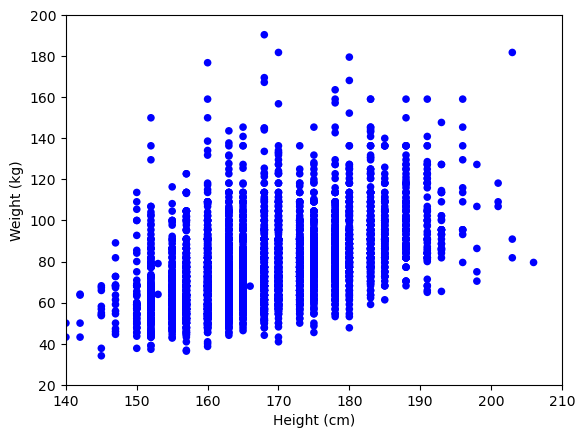

In [22]:
thinkplot.Scatter(heights, weights, alpha=1)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The data fall in obvious columns because they were rounded off.  We can reduce this visual artifact by adding some random noise to the data.

NOTE: The version of `Jitter` in the book uses noise with a uniform distribution.  Here I am using a normal distribution.  The normal distribution does a better job of blurring artifacts, but the uniform distribution might be more true to the data.

In [25]:
def Jitter(values, jitter=0.5):
    n = len(values)
    return np.random.normal(0, jitter, n) + values

Heights were probably rounded off to the nearest inch, which is 2.6 cm, so I'll add random values from -1.3 to 1.3.

In [28]:
heights = Jitter(heights, 1.3)
weights = Jitter(weights, 0.5)

And here's what the jittered data look like.

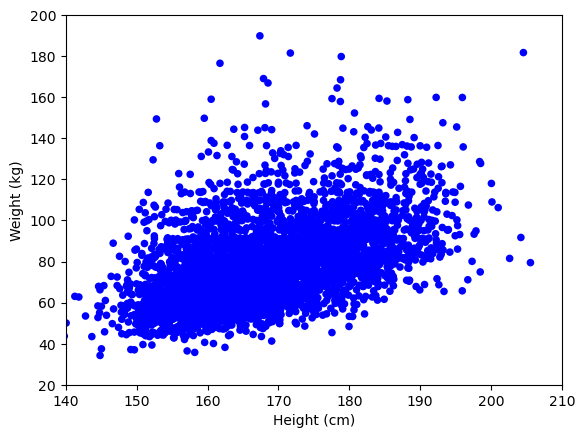

In [31]:
thinkplot.Scatter(heights, weights, alpha=1.0)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

The columns are gone, but now we have a different problem: saturation.  Where there are many overlapping points, the plot is not as dark as it should be, which means that the outliers are darker than they should be, which gives the impression that the data are more scattered than they actually are.

This is a surprisingly common problem, even in papers published in peer-reviewed journals.

We can usually solve the saturation problem by adjusting `alpha` and the size of the markers, `s`.

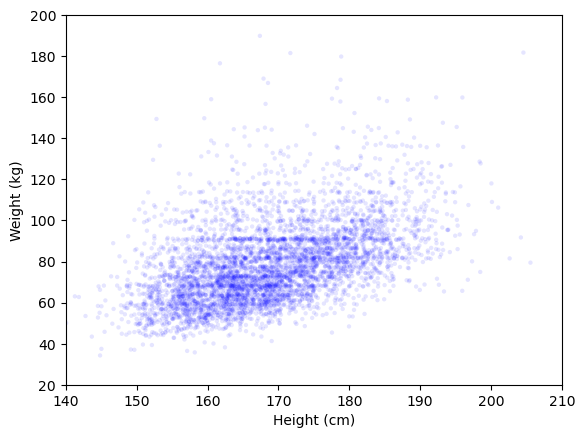

In [34]:
thinkplot.Scatter(heights, weights, alpha=0.1, s=10)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

That's better.  This version of the figure shows the location and shape of the distribution most accurately.  There are still some apparent columns and rows where, most likely, people reported their height and weight using rounded values.  If that effect is important, this figure makes it apparent; if it is not important, we could use more aggressive jittering to minimize it. 

An alternative to a scatter plot is something like a `HexBin` plot, which breaks the plane into bins, counts the number of respondents in each bin, and colors each bin in proportion to its count.

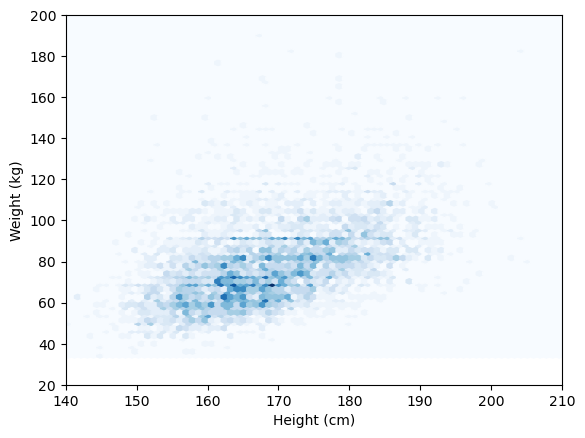

In [38]:
thinkplot.HexBin(heights, weights)
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

In this case the binned plot does a pretty good job of showing the location and shape of the distribution.  It obscures the row and column effects, which may or may not be a good thing.

**Exercise:**  So far we have been working with a subset of only 5000 respondents.  When we include the entire dataset, making an effective scatter plot can be tricky.  As an exercise, experiment with `Scatter` and `HexBin` to make a plot that represents the entire dataset well.

## Plotting percentiles

Sometimes a better way to get a sense of the relationship between variables is to divide the dataset into groups using one variable, and then plot percentiles of the other variable.

First I'll drop any rows that are missing height or weight.

In [58]:
cleaned = df.dropna(subset=['htm3', 'wtkg2'])

Then I'll divide the dataset into groups by height.

In [61]:
bins = np.arange(135, 210, 5)
indices = np.digitize(cleaned.htm3, bins)
groups = cleaned.groupby(indices)

Here are the number of respondents in each group:

In [64]:
for i, group in groups:
    print(i, len(group))

0 305
1 228
2 477
3 2162
4 18759
5 45761
6 70610
7 72138
8 61725
9 49938
10 43555
11 20077
12 7784
13 1777
14 405
15 131


Now we can compute the CDF of weight within each group.

In [67]:
mean_heights = [group.htm3.mean() for i, group in groups]
cdfs = [thinkstats2.Cdf(group.wtkg2) for i, group in groups]

And then extract the 25th, 50th, and 75th percentile from each group.

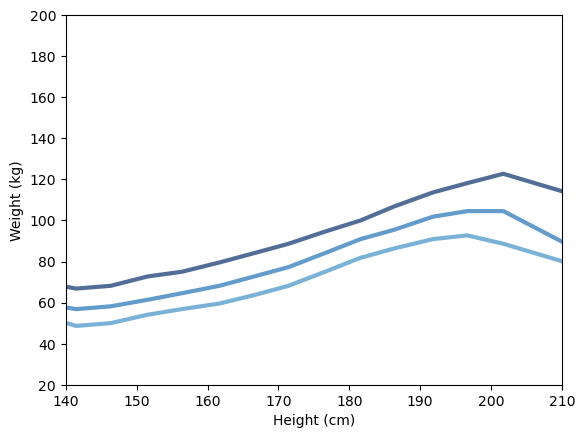

In [70]:
for percent in [75, 50, 25]:
    weight_percentiles = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(mean_heights, weight_percentiles, label=label)
    
thinkplot.Config(xlabel='Height (cm)',
                 ylabel='Weight (kg)',
                 axis=[140, 210, 20, 200],
                 legend=False)

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.  As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

## Correlation

The following function computes the covariance of two variables using NumPy's `dot` function.

In [76]:
def Cov(xs, ys, meanx=None, meany=None):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    if meanx is None:
        meanx = np.mean(xs)
    if meany is None:
        meany = np.mean(ys)

    cov = np.dot(xs-meanx, ys-meany) / len(xs)
    return cov

And here's an example:

In [79]:
heights, weights = cleaned.htm3, cleaned.wtkg2
Cov(heights, weights)

103.33290857697801

Covariance is useful for some calculations, but it doesn't mean much by itself.  The coefficient of correlation is a standardized version of covariance that is easier to interpret.

In [82]:
def Corr(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)

    meanx, varx = thinkstats2.MeanVar(xs)
    meany, vary = thinkstats2.MeanVar(ys)

    corr = Cov(xs, ys, meanx, meany) / np.sqrt(varx * vary)
    return corr

The correlation of height and weight is about 0.51, which is a moderately strong correlation.

In [85]:
Corr(heights, weights)

0.5087364789734671

NumPy provides a function that computes correlations, too:

In [88]:
np.corrcoef(heights, weights)

array([[1.        , 0.50873648],
       [0.50873648, 1.        ]])

The result is a matrix with self-correlations on the diagonal (which are always 1), and cross-correlations on the off-diagonals (which are always symmetric).

Pearson's correlation is not robust in the presence of outliers, and it tends to underestimate the strength of non-linear relationships.

Spearman's correlation is more robust, and it can handle non-linear relationships as long as they are monotonic.  Here's a function that computes Spearman's correlation:

In [92]:
import pandas as pd

def SpearmanCorr(xs, ys):
    xranks = pd.Series(xs).rank()
    yranks = pd.Series(ys).rank()
    return Corr(xranks, yranks)

For heights and weights, Spearman's correlation is a little higher:

In [95]:
SpearmanCorr(heights, weights)

0.5405846262320476

A Pandas `Series` provides a method that computes correlations, and it offers `spearman` as one of the options.

In [98]:
def SpearmanCorr(xs, ys):
    xs = pd.Series(xs)
    ys = pd.Series(ys)
    return xs.corr(ys, method='spearman')

The result is the same as for the one we wrote.

In [101]:
SpearmanCorr(heights, weights)

0.5405846262320483

An alternative to Spearman's correlation is to transform one or both of the variables in a way that makes the relationship closer to linear, and the compute Pearson's correlation.

In [104]:
Corr(cleaned.htm3, np.log(cleaned.wtkg2))

0.531728260598355

## Exercises

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age. Plot percentiles of birth weight versus mother’s age. Compute Pearson’s and Spearman’s correlations. How would you characterize the relationship between these variables?

In [108]:
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [110]:
import first
import warnings

warnings.simplefilter(action = 'ignore', category = FutureWarning)

live, firsts, others = first.MakeFrames()
live = live.dropna(subset=['agepreg', 'totalwgt_lb'])

In [111]:
mothers_age = live.agepreg
birth_weight = live.totalwgt_lb
pearson_corr = Corr(mothers_age, birth_weight)
spearman_corr = SpearmanCorr(mothers_age, birth_weight)
print(pearson_corr, spearman_corr)

0.06883397035410904 0.09461004109658226


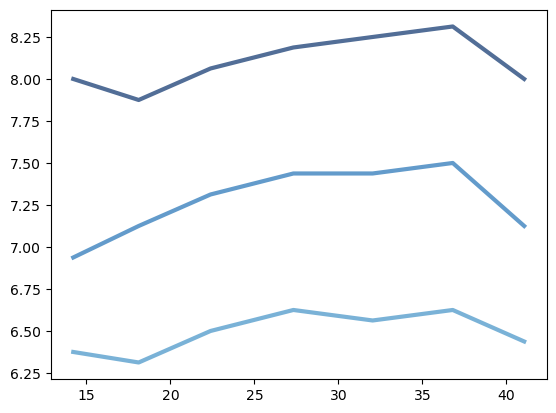

In [128]:
df = live
bins = np.arange(10, 50, 5)
indices = np.digitize(df.agepreg, bins)
groups = df.groupby(indices)

for i, group in groups:
    heights = [group.agepreg.mean() for i, group in groups]
    cdfs = [thinkstats2.Cdf(group.totalwgt_lb) for i, group in groups]

for percent in [75, 50, 25]:
    weights = [cdf.Percentile(percent) for cdf in cdfs]
    label = '%dth' % percent
    thinkplot.Plot(heights, weights, label=label)

In [ ]:
# The birth weight increases from ages 18 - 27 drastically but tends to not increase as much after age 27

# Chapter 8

Examples and Exercises from Think Stats, 2nd Edition

http://thinkstats2.com

Copyright 2016 Allen B. Downey

MIT License: https://opensource.org/licenses/MIT


In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [3]:
import numpy as np

import thinkstats2
import thinkplot

## The estimation game


Root mean squared error is one of several ways to summarize the average error of an estimation process.

In [6]:
def RMSE(estimates, actual):
    """Computes the root mean squared error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float RMSE
    """
    e2 = [(estimate-actual)**2 for estimate in estimates]
    mse = np.mean(e2)
    return np.sqrt(mse)

The following function simulates experiments where we try to estimate the mean of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and collect the mean and median of each sample.

In [8]:
import random

def Estimate1(n=7, iters=1000):
    """Evaluates RMSE of sample mean and median as estimators.

    n: sample size
    iters: number of iterations
    """
    mu = 0
    sigma = 1

    means = []
    medians = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for _ in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('Experiment 1')
    print('rmse xbar', RMSE(means, mu))
    print('rmse median', RMSE(medians, mu))
    
Estimate1()

Experiment 1
rmse xbar 0.3701676439247617
rmse median 0.4443394836617945


Using $\bar{x}$ to estimate the mean works a little better than using the median; in the long run, it minimizes RMSE.  But using the median is more robust in the presence of outliers or large errors.


## Estimating variance

The obvious way to estimate the variance of a population is to compute the variance of the sample, $S^2$, but that turns out to be a biased estimator; that is, in the long run, the average error doesn't converge to 0.

The following function computes the mean error for a collection of estimates.

In [10]:
def MeanError(estimates, actual):
    """Computes the mean error of a sequence of estimates.

    estimate: sequence of numbers
    actual: actual value

    returns: float mean error
    """
    errors = [estimate-actual for estimate in estimates]
    return np.mean(errors)

The following function simulates experiments where we try to estimate the variance of a population based on a sample with size `n=7`.  We run `iters=1000` experiments and two estimates for each sample, $S^2$ and $S_{n-1}^2$.

In [12]:
def Estimate2(n=7, iters=1000):
    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []
    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('mean error biased', MeanError(estimates1, sigma**2))
    print('mean error unbiased', MeanError(estimates2, sigma**2))
    
Estimate2()

mean error biased -0.12327370949087169
mean error unbiased 0.022847338927316364


The mean error for $S^2$ is non-zero, which suggests that it is biased.  The mean error for $S_{n-1}^2$ is close to zero, and gets even smaller if we increase `iters`.

## The sampling distribution

The following function simulates experiments where we estimate the mean of a population using $\bar{x}$, and returns a list of estimates, one from each experiment.

In [15]:
def SimulateSample(mu=90, sigma=7.5, n=9, iters=1000):
    xbars = []
    for j in range(iters):
        xs = np.random.normal(mu, sigma, n)
        xbar = np.mean(xs)
        xbars.append(xbar)
    return xbars

xbars = SimulateSample()

Here's the "sampling distribution of the mean" which shows how much we should expect $\bar{x}$ to vary from one experiment to the next.

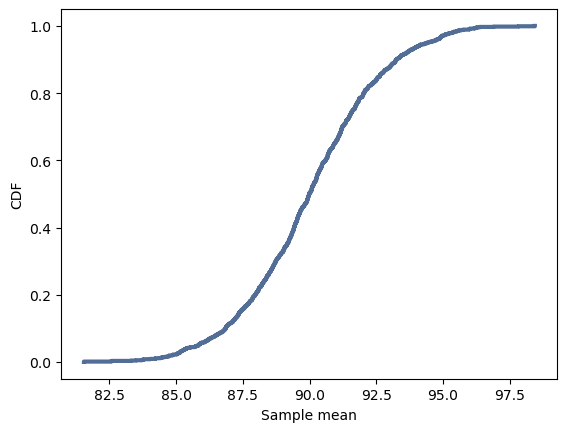

In [17]:
cdf = thinkstats2.Cdf(xbars)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Sample mean',
                 ylabel='CDF')

The mean of the sample means is close to the actual value of $\mu$.

In [19]:
np.mean(xbars)

90.02190512386066

An interval that contains 90% of the values in the sampling disrtribution is called a 90% confidence interval.

In [21]:
ci = cdf.Percentile(5), cdf.Percentile(95)
ci

(85.83189942865083, 94.41452514099271)

And the RMSE of the sample means is called the standard error.

In [23]:
stderr = RMSE(xbars, 90)
stderr

2.522118406855245

Confidence intervals and standard errors quantify the variability in the estimate due to random sampling.

## Estimating rates

The following function simulates experiments where we try to estimate the parameter $\lambda$ of an exponential distribution using the mean and median of a sample. 

In [26]:
def Estimate3(n=7, iters=1000):
    lam = 2

    Ls = []
    Lms = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        L = 1 / np.mean(xs)
        Lm = np.log(2) / thinkstats2.Median(xs)
        Ls.append(L)
        Lms.append(Lm)

    print('rmse L', RMSE(Ls, lam))
    print('rmse Lm', RMSE(Lms, lam))
    print('mean error L', MeanError(Ls, lam))
    print('mean error Lm', MeanError(Lms, lam))
    
Estimate3()

rmse L 1.1248501034639369
rmse Lm 1.8047379554736953
mean error L 0.32154335881259655
mean error Lm 0.4139222043759187


The RMSE is smaller for the sample mean than for the sample median.

But neither estimator is unbiased.

## Exercises

**Exercise:** Suppose you draw a sample with size n=10 from an exponential distribution with λ=2. Simulate this experiment 1000 times and plot the sampling distribution of the estimate L. Compute the standard error of the estimate and the 90% confidence interval.

Repeat the experiment with a few different values of `n` and make a plot of standard error versus `n`.



0.20667552610688628
(1.7272455424288033, 2.4128115222599327)


0.20667552610688628

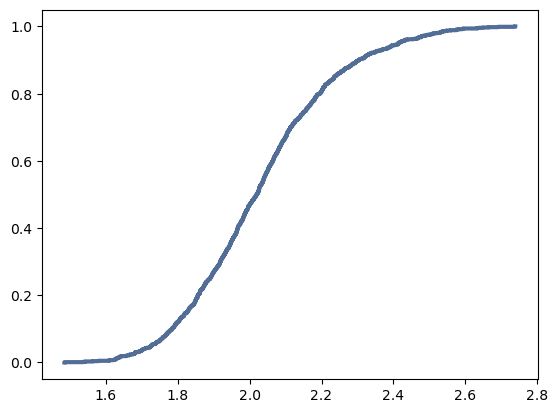

In [65]:
def SimulateSample(lam = 2, n = 100, iters = 1000):
    
    estimates = []
    for _ in range(iters):
        xs = np.random.exponential(1.0/lam, n)
        lamhat = 1.0 / np.mean(xs)
        estimates.append(lamhat)

    stderr = RMSE(estimates, lam)
    print(stderr)
    
    cdf = thinkstats2.Cdf(estimates)
    ci = cdf.Percentile(5), cdf.Percentile(95)
    print(ci)

    thinkplot.Cdf(cdf)

    return stderr

SimulateSample()

In [ ]:
# n = 10
# Standard error = 0.84
# Confidence interval = (1.29, 3.62)
# n = 50
# Standard error = 0.31
# Confidence interval = (1.62, 2.62)
# n = 100
# Standard error = 0.21
# Confidence interval = (1.73, 2.41)

# with increasing sample size, standard error and confidence interval decreases.

**Exercise:**  In this chapter we used $\bar{x}$ and median to estimate µ, and found that $\bar{x}$ yields lower MSE. Also, we used $S^2$ and $S_{n-1}^2$ to estimate σ, and found that $S^2$ is biased and $S_{n-1}^2$ unbiased.
Run similar experiments to see if $\bar{x}$ and median are biased estimates of µ. Also check whether $S^2$ or $S_{n-1}^2$ yields a lower MSE.

In [81]:
def Estimates1(n = 7, iters = 1000):

    mu = 0
    sigma = 1

    means = []
    medians = []

    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        xbar = np.mean(xs)
        median = np.median(xs)
        means.append(xbar)
        medians.append(median)

    print('xbar', MeanError(means,mu))
    print('median', MeanError(medians, mu))

Estimates1()

xbar 0.008929113496680423
median 0.0074448713821417215


In [83]:
def Estimates2(n = 7, iters = 1000):

    mu = 0
    sigma = 1

    estimates1 = []
    estimates2 = []

    for _ in range(iters):
        xs = [random.gauss(mu, sigma) for i in range(n)]
        biased = np.var(xs)
        unbiased = np.var(xs, ddof=1)
        estimates1.append(biased)
        estimates2.append(unbiased)

    print('biased', RMSE(estimates1, sigma**2))
    print('unbiased', RMSE(estimates2, sigma**2))

Estimates2()

biased 0.5097289121995383
unbiased 0.5673320886064631
